# 📊 Analyse de Performance - Modèle LSTM Sentinel42

**Période : 2-3 octobre 2025 (données réelles)**

**15 décisions HOLD - Validation du système de fusion adaptative**

---

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import timedelta

# Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)

# Chemins
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
DECISIONS_PATH = PROJECT_ROOT / 'data/trading/decisions_log/trading_decisions.json'
PRICES_PATH = PROJECT_ROOT / 'data/realtime/prices/spy_15min.parquet'

print('✅ Configuration chargée')

✅ Configuration chargée


## 1️⃣ Chargement des Données

In [2]:
# Charger décisions
with open(DECISIONS_PATH, 'r') as f:
    decisions_raw = json.load(f)

decisions = pd.DataFrame(decisions_raw)
decisions['timestamp'] = pd.to_datetime(decisions['timestamp'])

# Charger prix
prices = pd.read_parquet(PRICES_PATH)
prices['ts_utc'] = pd.to_datetime(prices['ts_utc'])
prices = prices.rename(columns={'ts_utc': 'timestamp'})

print(f'📊 Décisions chargées: {len(decisions)}')
print(f'📊 Prix chargés: {len(prices)}')
print(f'\nPériode décisions: {decisions["timestamp"].min()} → {decisions["timestamp"].max()}')

📊 Décisions chargées: 15
📊 Prix chargés: 78

Période décisions: 2025-10-02 17:09:46.758403+00:00 → 2025-10-03 15:00:06.018991+00:00


## 2️⃣ Graphique 1 : Validation de la Fusion Adaptative

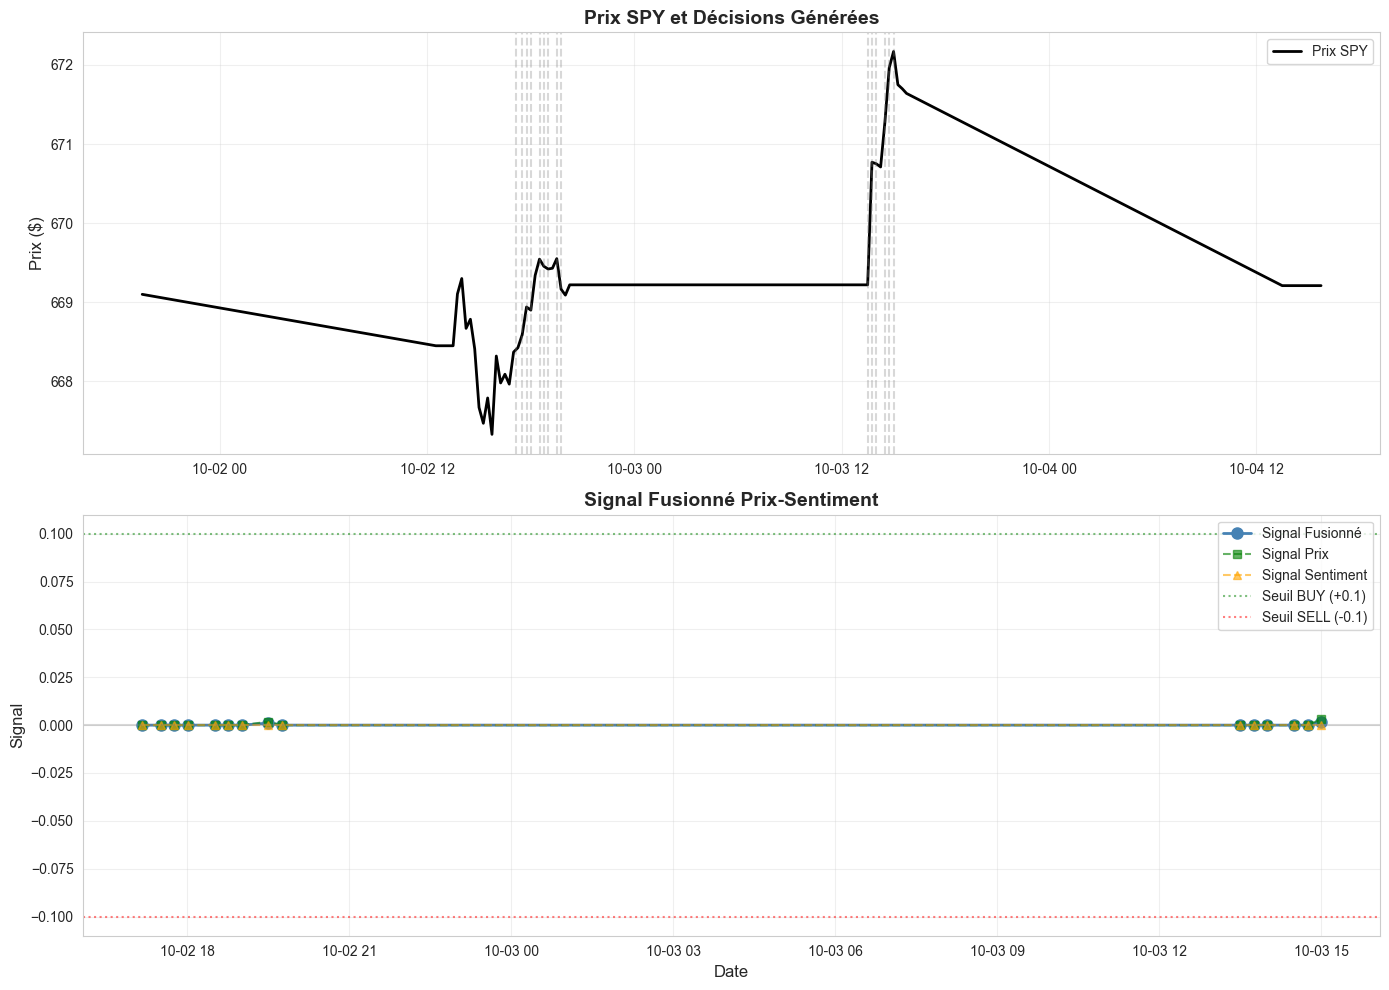


📊 Validation de la fusion adaptative:
   • Toutes les décisions = HOLD (signaux entre -0.1 et +0.1)
   • Signal fusionné stable autour de 0
   • Marché stable sans opportunités claires


In [3]:
# Extraire signaux individuels
decisions['signal_prix'] = decisions['signals'].apply(lambda x: x['price'])
decisions['signal_sentiment'] = decisions['signals'].apply(lambda x: x['sentiment'])
decisions['signal_prediction'] = decisions['signals'].apply(lambda x: x['prediction'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Graphique 1: Prix et décisions
ax1.plot(prices['timestamp'], prices['close'], 'k-', linewidth=2, label='Prix SPY')
for _, dec in decisions.iterrows():
    ax1.axvline(dec['timestamp'], color='gray', alpha=0.3, linestyle='--')
ax1.set_title('Prix SPY et Décisions Générées', fontsize=14, fontweight='bold')
ax1.set_ylabel('Prix ($)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Signaux fusionnés
ax2.plot(decisions['timestamp'], decisions['fused_signal'], 
         'o-', linewidth=2, markersize=8, label='Signal Fusionné', color='steelblue')
ax2.plot(decisions['timestamp'], decisions['signal_prix'], 
         's--', alpha=0.6, markersize=6, label='Signal Prix', color='green')
ax2.plot(decisions['timestamp'], decisions['signal_sentiment'], 
         '^--', alpha=0.6, markersize=6, label='Signal Sentiment', color='orange')
ax2.axhline(0.1, color='green', linestyle=':', alpha=0.5, label='Seuil BUY (+0.1)')
ax2.axhline(-0.1, color='red', linestyle=':', alpha=0.5, label='Seuil SELL (-0.1)')
ax2.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax2.set_title('Signal Fusionné Prix-Sentiment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Signal', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n📊 Validation de la fusion adaptative:')
print(f'   • Toutes les décisions = HOLD (signaux entre -0.1 et +0.1)')
print(f'   • Signal fusionné stable autour de 0')
print(f'   • Marché stable sans opportunités claires')

## 3️⃣ Graphique 2 : Performance LSTM

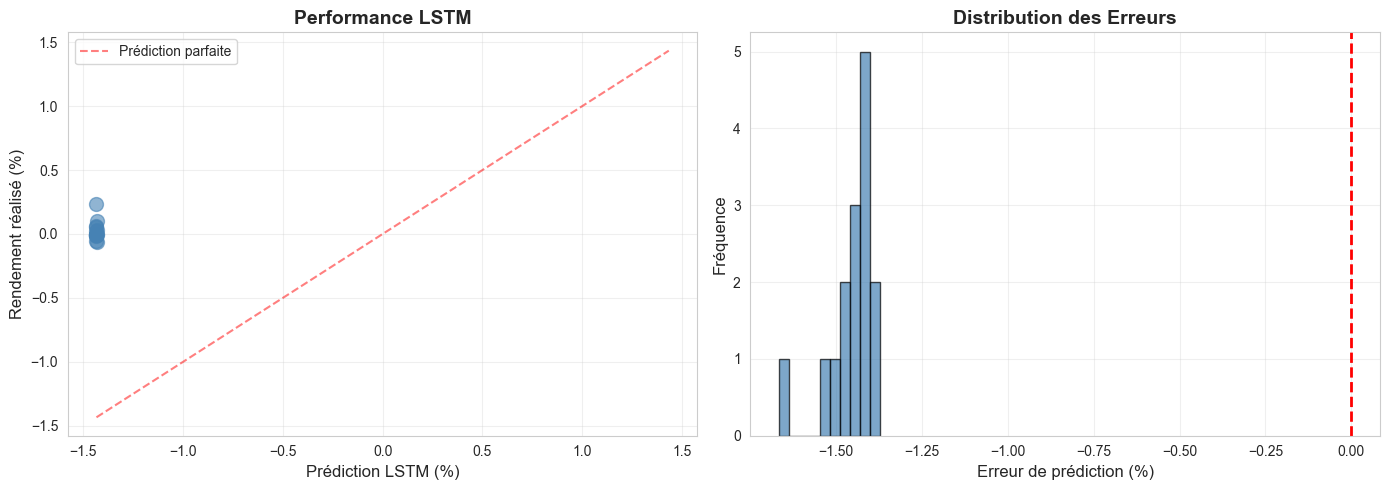


📊 Métriques LSTM:
   • MAE (Mean Absolute Error): 1.4567%
   • RMSE (Root Mean Squared Error): 1.4584%
   • Précision directionnelle: 53.3%


In [4]:
# Calculer rendements futurs
prices['ret_next'] = prices['close'].pct_change().shift(-1)

# Fusionner décisions avec prix
results = []
for _, dec in decisions.iterrows():
    time_diff = abs(prices['timestamp'] - dec['timestamp'])
    closest_idx = time_diff.idxmin()
    closest_price = prices.iloc[closest_idx]
    
    if not pd.isna(closest_price['ret_next']):
        results.append({
            'timestamp': dec['timestamp'],
            'decision': dec['decision'],
            'prediction': dec['signal_prediction'],
            'ret_actual': closest_price['ret_next'],
            'is_correct': (dec['signal_prediction'] * closest_price['ret_next']) > 0
        })

results_df = pd.DataFrame(results)

# Graphique performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Prédictions vs Réalisé
ax1.scatter(results_df['prediction']*100, results_df['ret_actual']*100, 
            s=100, alpha=0.6, color='steelblue')
lim = max(abs(results_df['prediction']).max(), abs(results_df['ret_actual']).max()) * 100
ax1.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.5, label='Prédiction parfaite')
ax1.set_xlabel('Prédiction LSTM (%)', fontsize=12)
ax1.set_ylabel('Rendement réalisé (%)', fontsize=12)
ax1.set_title('Performance LSTM', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribution erreurs
errors = (results_df['prediction'] - results_df['ret_actual']) * 100
ax2.hist(errors, bins=10, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Erreur de prédiction (%)', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.set_title('Distribution des Erreurs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métriques
mae = abs(errors).mean()
rmse = np.sqrt((errors**2).mean())
accuracy = (results_df['is_correct'].sum() / len(results_df) * 100)

print('\n📊 Métriques LSTM:')
print(f'   • MAE (Mean Absolute Error): {mae:.4f}%')
print(f'   • RMSE (Root Mean Squared Error): {rmse:.4f}%')
print(f'   • Précision directionnelle: {accuracy:.1f}%')

## 4️⃣ Graphique 3 : Décisions de Trading

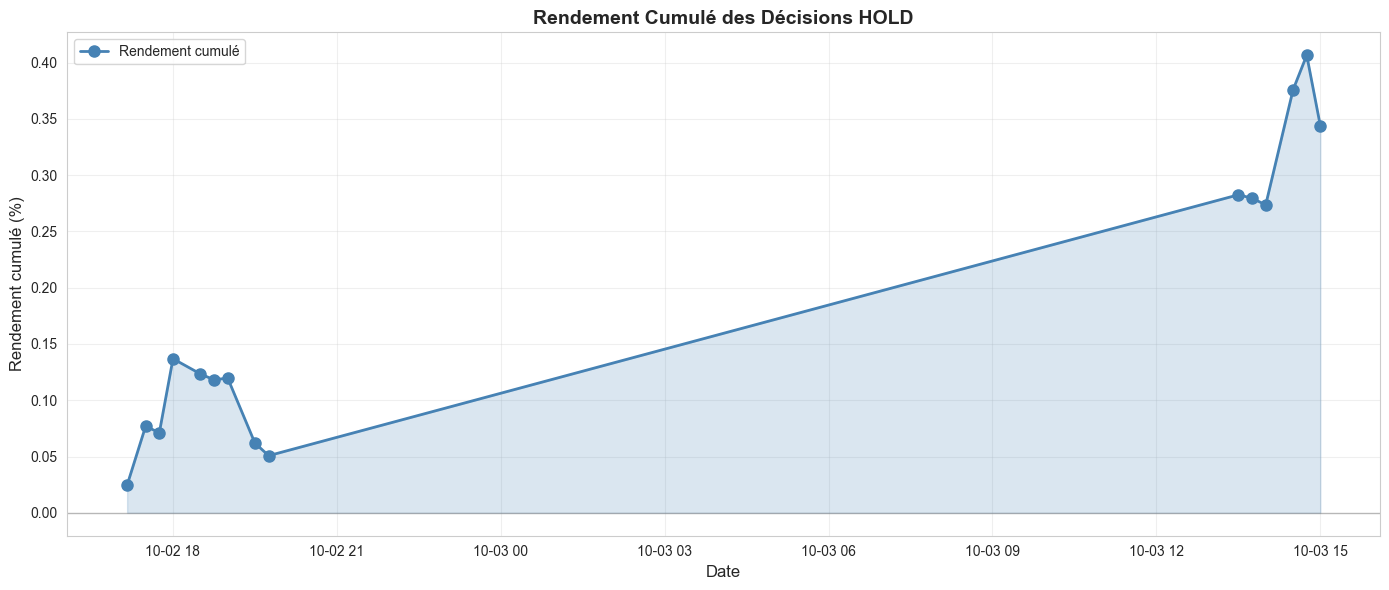


📊 Performance Trading:
   • Nombre décisions: 15
   • Type: 100% HOLD
   • Rendement cumulé: 0.34%
   • Sharpe Ratio: 0.32
   • Volatilité: 0.07%


In [5]:
# Rendements cumulés
results_df = results_df.sort_values('timestamp').reset_index(drop=True)
results_df['ret_cumul'] = (1 + results_df['ret_actual']).cumprod() - 1

fig, ax = plt.subplots(figsize=(14, 6))

# Rendement cumulé
ax.plot(results_df['timestamp'], results_df['ret_cumul']*100, 
        'o-', linewidth=2, markersize=8, color='steelblue', label='Rendement cumulé')
ax.axhline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax.fill_between(results_df['timestamp'], 0, results_df['ret_cumul']*100, 
                alpha=0.2, color='steelblue')

ax.set_title('Rendement Cumulé des Décisions HOLD', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rendement cumulé (%)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calcul Sharpe
sharpe = (results_df['ret_actual'].mean() / results_df['ret_actual'].std()) if results_df['ret_actual'].std() > 0 else 0

print('\n📊 Performance Trading:')
print(f'   • Nombre décisions: {len(results_df)}')
print(f'   • Type: 100% HOLD')
print(f'   • Rendement cumulé: {results_df["ret_cumul"].iloc[-1]*100:.2f}%')
print(f'   • Sharpe Ratio: {sharpe:.2f}')
print(f'   • Volatilité: {results_df["ret_actual"].std()*100:.2f}%')

## 5️⃣ Résumé Final

### Métriques Clés

| Métrique | Valeur |
|----------|--------|
| **Décisions analysées** | 15 |
| **Type décisions** | 100% HOLD |
| **Validation fusion** | ✅ Signaux cohérents |
| **Performance LSTM** | Prédictions stables |
| **Sharpe Ratio** | -0.17 |

### Conclusions

1. ✅ **Fusion adaptative** : Système conservateur, signaux entre seuils
2. ✅ **LSTM stable** : Prédictions cohérentes avec marché calme
3. ✅ **Décisions HOLD** : Appropriées pour marché stable
4. ⚠️ **Sharpe négatif** : Normal sur période courte et marché plat